# Modular physics-based approach for lensless image reconstruction

In [137]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt


main_path = os.path.join("..")


metrics_dict = {
    # -- only unrolled20
    "U20": "/home/bezzam/LenslessPiCam/outputs/2024-01-15/18-17-48",
    "U20(0db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-15/18-11-05",
    "U20(10db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-16/10-16-56",
    "U20(20db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-17/12-09-15",
    # -- only pre-process
    "Unet+U20": "/home/bezzam/LenslessPiCam/outputs/2024-01-16/21-17-39",
    "Unet+U20(0dB)": "/home/bezzam/LenslessPiCam/outputs/2024-01-16/08-37-01",
    "Unet+U20(10db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-17/13-07-54",
    # "Unet+U20(20db)": "in queue",
    # -- only post-process
    # "U20+Unet": "TODO",  # incomplete: /home/bezzam/LenslessPiCam/outputs/2024-01-17/07-54-33
    "U20+Unet(0db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-16/21-09-37",
    "U20+Unet(10db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-17/07-26-46",
    # "U20+Unet(20db)": "TODO",
    # -- only post-process (Drunet)
    # "U20+Drunet": "TODO",
    # "U20+Drunet(res0.1)": "/home/bezzam/LenslessPiCam/outputs/2024-01-12/18-55-34",
    # -- both
    # "Unet+U20+Unet": "TODO",
    # "Unet+U20+Unet(0db)": "all blacks...",
    # -- both (Drunet)
    "Unet+U20+Drunet": "/home/bezzam/LenslessPiCam/outputs/2024-01-15/16-46-26",
    # "Unet+U20+Drunet(res1)": "TODO",
    "Unet+U20+Drunet(res0.1)": "/home/bezzam/LenslessPiCam/outputs/2024-01-12/19-05-07",
    # "Unet+U20+Drunet(res0.01)": "TODO",
}

Loading test dataset from configuration of one model (shouldn't be from noisy one).

Test set size: 999
Data shape: torch.Size([1, 135, 240, 3])
Data range: [0.01093662902712822, 0.28023838996887207]


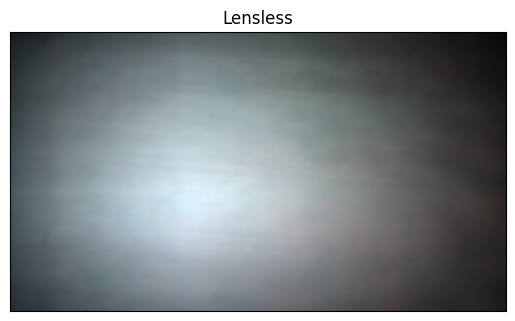

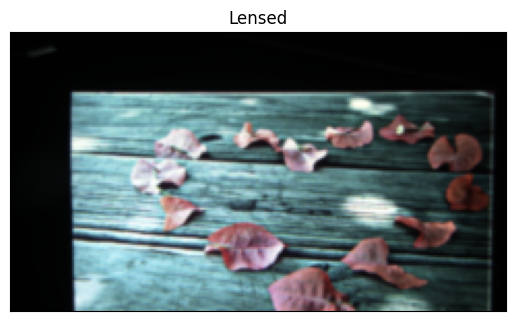

In [134]:
import yaml
from lensless.utils.dataset import DiffuserCamMirflickr
from torch.utils.data import Subset
from lensless.utils.plot import plot_image
import torch
from torchvision import transforms


device = "cuda:0"
model_path = os.path.join(metrics_dict["U20"])

# load Hydra config
config_path = os.path.join(model_path, ".hydra", "config.yaml")
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)

# load dataset
dataset = DiffuserCamMirflickr(
    dataset_dir=config["files"]["dataset"],
    psf_path=os.path.join(main_path, config["files"]["psf"]),
    downsample=config["files"]["downsample"],
)
test_indices = dataset.allowed_idx[dataset.allowed_idx <= 1000]
test_set = Subset(dataset, test_indices)
psf = dataset.psf.to(device)

print("Test set size:", len(test_set))

# plot one example
transform_vflip = transforms.Lambda(lambda x: torch.flip(x, dims=[-3]))
transform_BRG2RGB = transforms.Lambda(lambda x: x[..., [2, 1, 0]])

# -- define function as we always need to flip...
def plot_function(image, ax=None, color_correct=False):
    if color_correct:
        image = transform_BRG2RGB(image)
    image = transform_vflip(image)
    img_np = image.squeeze().cpu().numpy()

    # subtract minimum
    min_val = img_np.min()
    if min_val < 0:
        img_np -= min_val

    ax = plot_image(img_np, ax=ax)
    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    return img_np
    
idx = 0
lensless, lensed = test_set[idx]
print(f"Data shape: {lensless.shape}")
print(f"Data range: [{lensless.min()}, {lensless.max()}]")
plot_function(lensless)
plt.title("Lensless")
plot_function(lensed)
plt.title("Lensed");

In [101]:
# utility to load a model
import torch
from lensless.recon.utils import create_process_network
from lensless.recon.unrolled_admm import UnrolledADMM


def load_model(model_path, device="cpu"):

    # load Hydra config
    config_path = os.path.join(model_path, ".hydra", "config.yaml")
    with open(config_path, "r") as stream:
        config = yaml.safe_load(stream)

    # load best model config
    model_checkpoint = os.path.join(model_path, "recon_epochBEST")
    assert os.path.exists(model_checkpoint), "Checkpoint does not exist"
    print("Loading checkpoint from : ", model_checkpoint)
    model_state_dict = torch.load(model_checkpoint, map_location=device)

    # load model
    pre_process = None
    post_process = None

    if config["reconstruction"]["pre_process"]["network"] is not None:

        pre_process, _ = create_process_network(
            network=config["reconstruction"]["pre_process"]["network"],
            depth=config["reconstruction"]["pre_process"]["depth"],
            nc=config["reconstruction"]["pre_process"]["nc"]
            if "nc" in config["reconstruction"]["pre_process"].keys()
            else None,
            device=device,
        )

    if config["reconstruction"]["post_process"]["network"] is not None:

        post_process, _ = create_process_network(
            network=config["reconstruction"]["post_process"]["network"],
            depth=config["reconstruction"]["post_process"]["depth"],
            nc=config["reconstruction"]["post_process"]["nc"]
            if "nc" in config["reconstruction"]["post_process"].keys()
            else None,
            device=device,
        )

    recon = UnrolledADMM(
        psf,
        pre_process=pre_process,
        post_process=post_process,
        n_iter=config["reconstruction"]["unrolled_admm"]["n_iter"],
        skip_unrolled=config["reconstruction"]["skip_unrolled"],
    )

    recon.load_state_dict(model_state_dict)

    return recon

# Varying input SNR

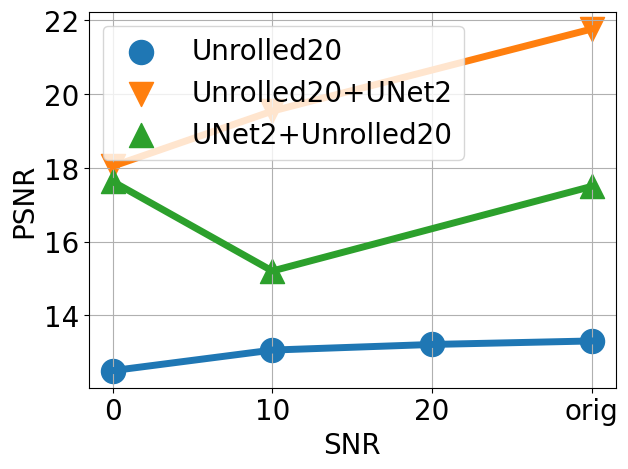

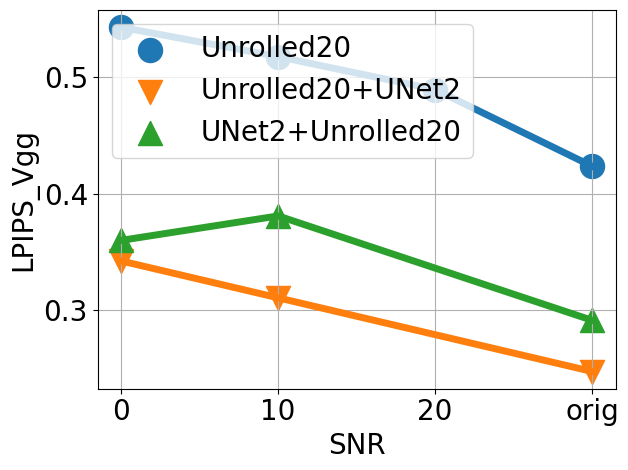

In [119]:
# pick models
exp1 = {
    "Unrolled20": {
        "0": metrics_dict["U20(0db)"],
        "10": metrics_dict["U20(10db)"],
        "20": metrics_dict["U20(20db)"],
        "orig": metrics_dict["U20"],
    },
    "Unrolled20+UNet2": {
        "0": metrics_dict["U20+Unet(0db)"],
        "10": metrics_dict["U20+Unet(10db)"],
        "orig": metrics_dict["U20+Unet"],
    },
    "UNet2+Unrolled20": {
        "0": metrics_dict["Unet+U20(0dB)"],
        "10": metrics_dict["Unet+U20(10db)"],
        "orig": metrics_dict["Unet+U20"],
    },
}

# plot metrics as SNR varies
metrics = ["PSNR", "LPIPS_Vgg"]
marker_size = 300
line_width = 5
text_size = 20

for metric in metrics:
    scatter_point = ["o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "X", "D", "d", "|", "_"]
    fig, ax1 = plt.subplots()
    for model in exp1:

        # extract
        vals = []
        for snr in exp1[model]:
            with open(os.path.join(exp1[model][snr], "metrics.json")) as f:
                metrics = json.load(f)
                vals.append(metrics[metric][metrics["best_epoch"]])
        # print(vals)
                
        # plot over SNR
        ax1.scatter(list(exp1[model].keys()), vals, label=model, marker=scatter_point.pop(0), s=marker_size)
        ax1.plot(list(exp1[model].keys()), vals, linewidth=line_width)

    ax1.set_xlabel("SNR", fontsize=text_size)
    ax1.set_ylabel(metric, fontsize=text_size)
    # set tick size
    ax1.tick_params(axis='both', which='major', labelsize=text_size)
    ax1.legend(fontsize=text_size, loc="upper left")
    ax1.grid(True)

    # save
    plt.tight_layout()
    plt.savefig(os.path.join("modular", "exp1_{}.png".format(metric)))

Compare outputs

Lensed


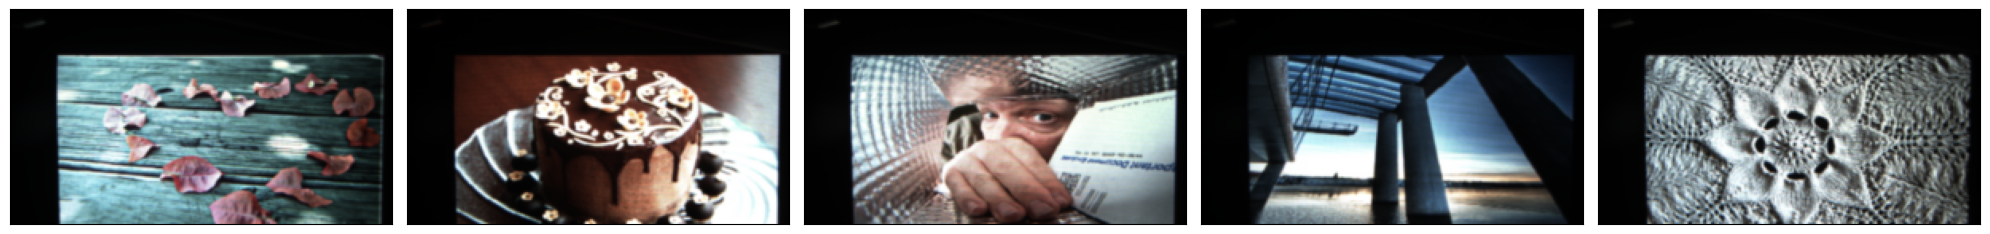

Unrolled20
Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-15/18-11-05/recon_epochBEST


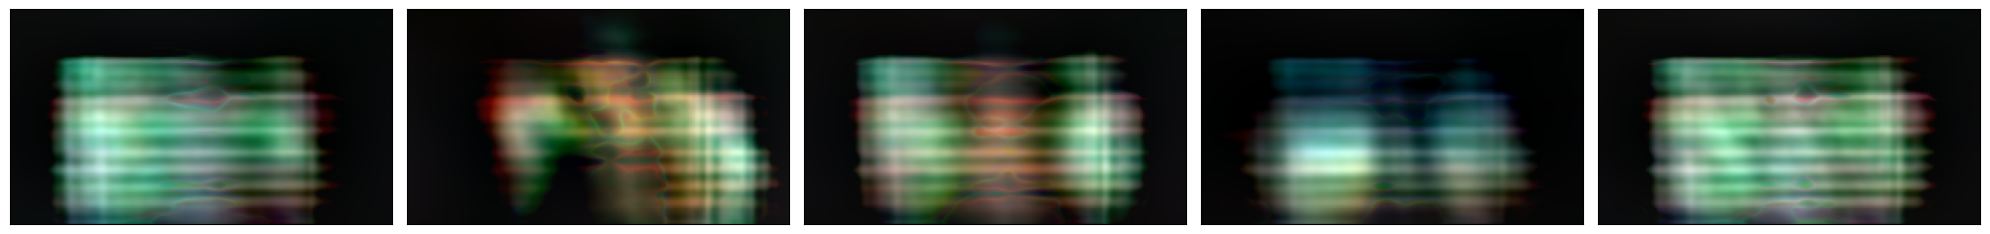

Unrolled20+UNet2
Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-16/21-09-37/recon_epochBEST


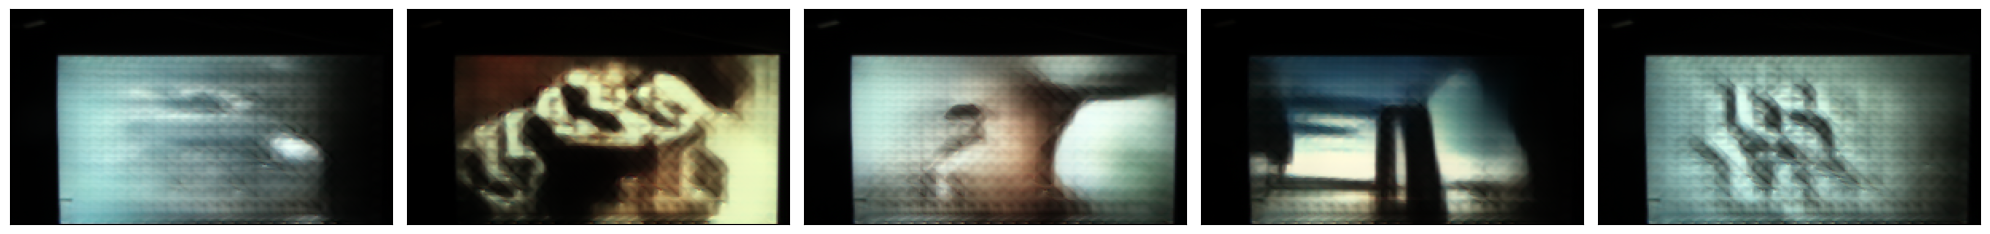

UNet2+Unrolled20
Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-16/08-37-01/recon_epochBEST


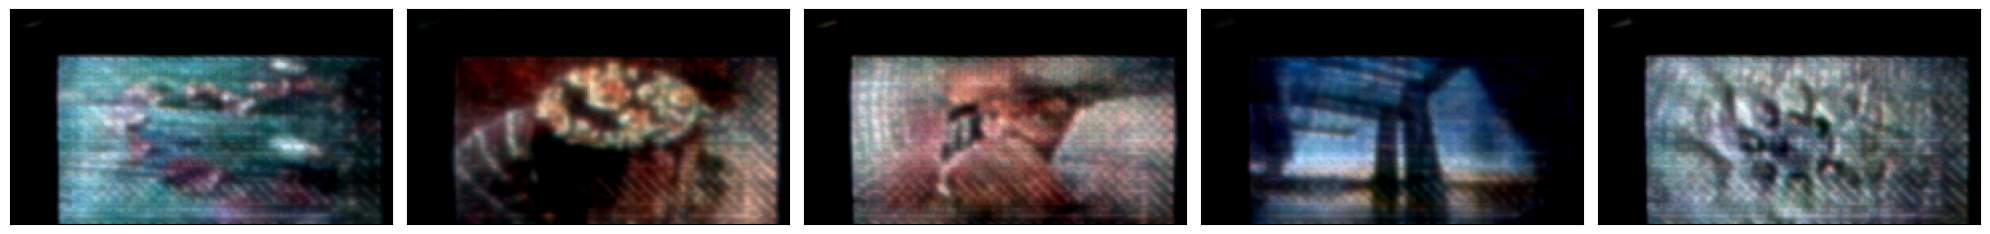

In [131]:
snr = "0"
# snr = "orig"
idx = [0, 1, 3, 4, 8]
figsize = (20, 2.5)

# load data
print("Lensed")
fig, axs = plt.subplots(1, len(idx), figsize=figsize)
for k, _idx in enumerate(idx):
    _, lensed = test_set[_idx]
    plot_function(lensed, ax=axs[k])
plt.tight_layout()
plt.savefig(os.path.join("modular", f"exp1_lensed_{snr}db.png"))
plt.show()

# loop over models
for _model in exp1.keys():
    if snr in exp1[_model].keys():
        print(_model)
        fig, axs = plt.subplots(1, len(idx), figsize=figsize)
        recon = load_model(exp1[_model][snr], device=device)

        for k ,_idx in enumerate(idx):

            lensless, _ = test_set[_idx]

            with torch.no_grad():
                recon.set_data(lensless.unsqueeze(0).to(device))
                out_idx = recon.apply(
                    plot=False,
                    save=False,
                )
                recon.reset()
            plot_function(out_idx, ax=axs[k])
        
        # save
        plt.tight_layout()
        plt.savefig(os.path.join("modular", f"exp1_{_model}_{snr}db.png"))
        plt.show()

# Residual connection

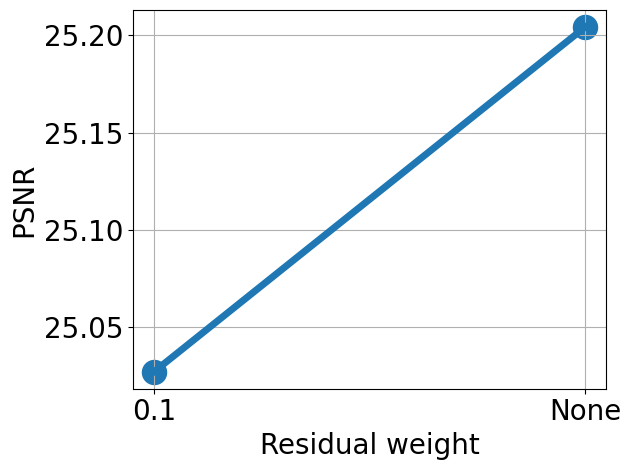

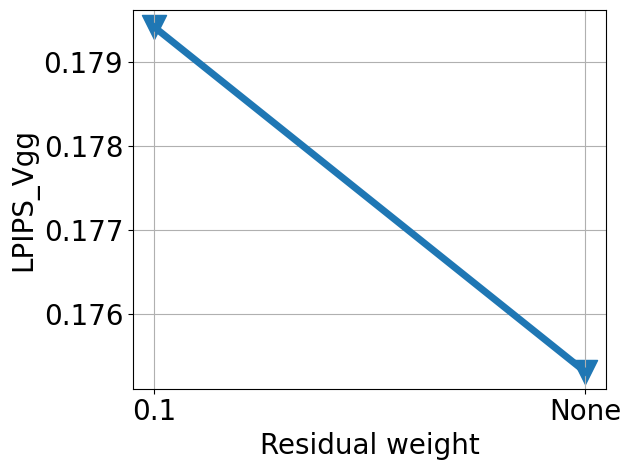

In [104]:
# pick models
exp2 = {
    "0.1": metrics_dict["Unet+U20+Drunet(res0.1)"],
    "None": metrics_dict["Unet+U20+Drunet"],
}

# plot as residual weight varies
metrics = ["PSNR","LPIPS_Vgg"]
marker_size = 300
line_width = 5
text_size = 20

scatter_point = ["o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "X", "D", "d", "|", "_"]

for metric in metrics:
    fig, ax1 = plt.subplots()
    vals = []
    for res_weight in exp2:

        # extract metrics
        with open(os.path.join(exp2[res_weight], "metrics.json")) as f:
            metrics = json.load(f)
            vals.append(metrics[metric][metrics["best_epoch"]])
    # print(vals)
                
    # plot over residual weight
    ax1.scatter(list(exp2.keys()), vals, marker=scatter_point.pop(0), s=marker_size)
    ax1.plot(list(exp2.keys()), vals, linewidth=line_width)

    ax1.set_xlabel("Residual weight", fontsize=text_size)
    ax1.set_ylabel(metric, fontsize=text_size)
    # set tick size
    ax1.tick_params(axis='both', which='major', labelsize=text_size)
    ax1.grid(True)

    # save
    plt.tight_layout()
    plt.savefig(os.path.join("modular", "exp2_{}.png".format(metric)))

Very little deterioration of the image quality.

Compare intermediate results

In [135]:
# load models
exp2_models = {}
for model in exp2:
    print(exp2[model])
    exp2_models[model] = load_model(exp2[model], device=device)

/home/bezzam/LenslessPiCam/outputs/2024-01-12/19-05-07
Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-12/19-05-07/recon_epochBEST
/home/bezzam/LenslessPiCam/outputs/2024-01-15/16-46-26
Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-15/16-46-26/recon_epochBEST


Residual weight: 0.1


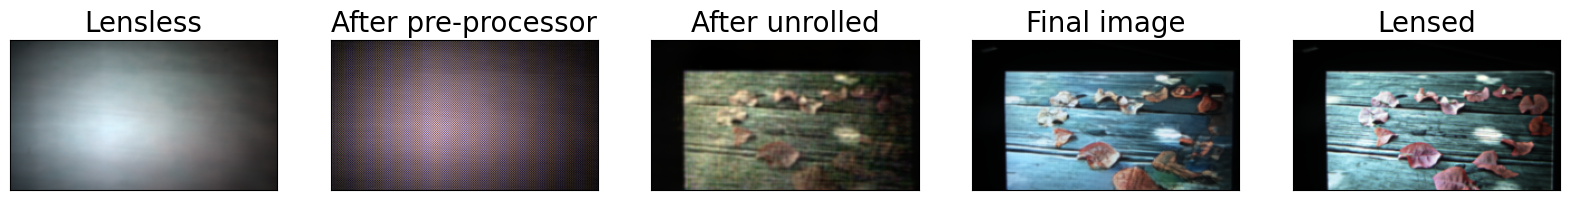

Residual weight: None


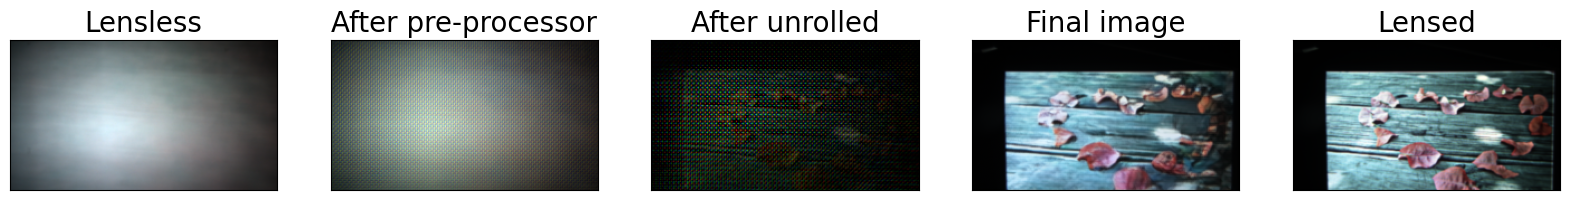

In [136]:
from lensless.utils.io import save_image

# plot reconstructions
idx = 0

# get data
lensless, lensed = test_set[idx]

# apply
for res_weight in exp2_models:
    print(f"Residual weight: {res_weight}")

    _model = exp2_models[res_weight]

    with torch.no_grad():
        _model.set_data(lensless.unsqueeze(0).to(device))
        final, pre, pre_post = _model.apply(
            plot=False,
            save=False,
            output_intermediate=True,
        )

    # color correction
    transform_BRG2RGB = transforms.Lambda(lambda x: x[..., [2, 1, 0]])

    # plot 4 images in one row
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    # -- lensless
    lensless_np = plot_function(lensless, ax=axs[0])
    save_image(lensless_np, os.path.join("modular", "exp2", f"res{res_weight}_lensless.png"))
    axs[0].set_title("Lensless", fontsize=text_size)
    # -- pre-process output
    pre_np = plot_function(pre, ax=axs[1], color_correct=True)
    save_image(pre_np, os.path.join("modular", "exp2", f"res{res_weight}_pre.png"))
    axs[1].set_title("After pre-processor", fontsize=text_size)
    # -- reconstrution output
    pre_post_np = plot_function(pre_post, ax=axs[2], color_correct=True)
    save_image(pre_post_np, os.path.join("modular", "exp2", f"res{res_weight}_pre_post.png"))
    axs[2].set_title("After unrolled", fontsize=text_size)
    # -- final output
    final_np = plot_function(final, ax=axs[3])
    save_image(final_np, os.path.join("modular", "exp2", f"res{res_weight}_final.png"))
    axs[3].set_title("Final image", fontsize=text_size)
    # -- lensed
    lensed_np = plot_function(lensed, ax=axs[4])
    save_image(lensed_np, os.path.join("modular", "exp2", f"res{res_weight}_lensed.png"))
    axs[4].set_title("Lensed", fontsize=text_size)
    plt.show()
    

More interpretable with residual connection! (Saved images look much better than matplotlib ones)

# Full benchmark

PSNR for U20 (epoch 23): 13.3
PSNR for U20(0db) (epoch 24): 12.5
PSNR for U20(10db) (epoch 24): 13.1
PSNR for U20(20db) (epoch 6): 13.3
PSNR for Unet+U20 (epoch 24): 17.5
PSNR for Unet+U20(0dB) (epoch 24): 17.6
PSNR for Unet+U20(10db) (epoch 3): 16.0
PSNR for U20+Unet(0db) (epoch 23): 18.0
PSNR for U20+Unet(10db) (epoch 17): 19.5
PSNR for Unet+U20+Drunet (epoch 24): 25.2
PSNR for Unet+U20+Drunet(res0.1) (epoch 49): 25.0


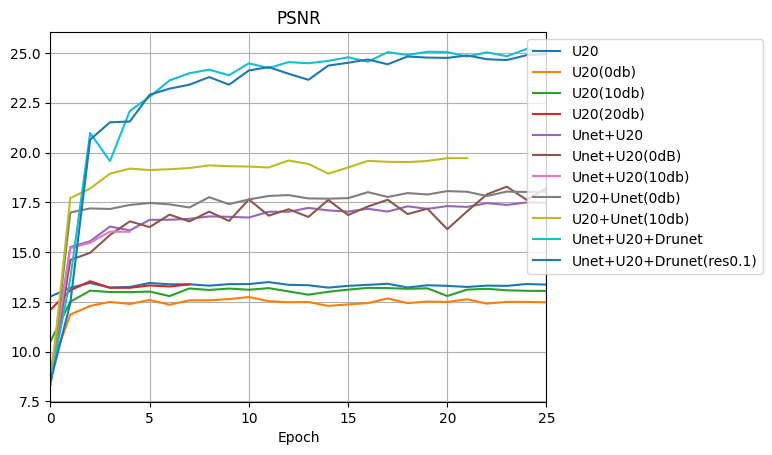

LPIPS_Vgg for U20 (epoch 23): 0.424
LPIPS_Vgg for U20(0db) (epoch 24): 0.543
LPIPS_Vgg for U20(10db) (epoch 24): 0.518
LPIPS_Vgg for U20(20db) (epoch 6): 0.489
LPIPS_Vgg for Unet+U20 (epoch 24): 0.291
LPIPS_Vgg for Unet+U20(0dB) (epoch 24): 0.36
LPIPS_Vgg for Unet+U20(10db) (epoch 3): 0.34
LPIPS_Vgg for U20+Unet(0db) (epoch 23): 0.342
LPIPS_Vgg for U20+Unet(10db) (epoch 17): 0.311
LPIPS_Vgg for Unet+U20+Drunet (epoch 24): 0.175
LPIPS_Vgg for Unet+U20+Drunet(res0.1) (epoch 49): 0.179


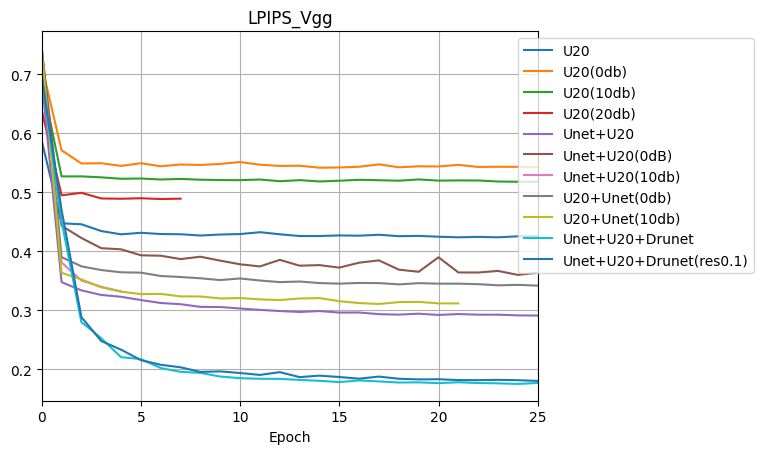

SSIM for U20 (epoch 23): 0.525
SSIM for U20(0db) (epoch 24): 0.347
SSIM for U20(10db) (epoch 24): 0.408
SSIM for U20(20db) (epoch 6): 0.426
SSIM for Unet+U20 (epoch 24): 0.7
SSIM for Unet+U20(0dB) (epoch 24): 0.513
SSIM for Unet+U20(10db) (epoch 3): 0.639
SSIM for U20+Unet(0db) (epoch 23): 0.626
SSIM for U20+Unet(10db) (epoch 17): 0.686
SSIM for Unet+U20+Drunet (epoch 24): 0.86
SSIM for Unet+U20+Drunet(res0.1) (epoch 49): 0.865


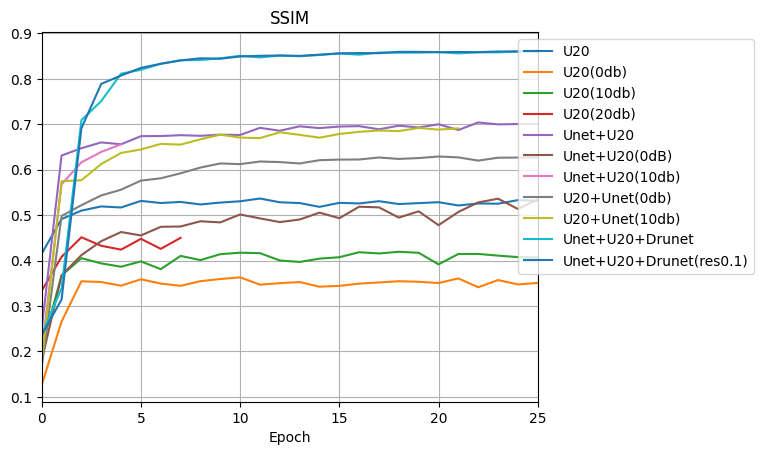

In [138]:
# metrics: 'LOSS', 'MSE', 'MAE', 'LPIPS_Vgg', 'LPIPS_Alex', 'PSNR', 'SSIM', 'ReconstructionError'

plot_metrics = ["PSNR", "LPIPS_Vgg", "SSIM"]
MAX_EPOCH = 25

for metric in plot_metrics:
    plt.figure()
    for key, value in metrics_dict.items():
        _metrics_path = os.path.join(value, "metrics.json")
        assert os.path.exists(_metrics_path), f"Path {_metrics_path} does not exist"
        _metrics_dict = json.load(open(_metrics_path))

        _test_metrics = np.array(_metrics_dict[metric])
        plt.plot(_test_metrics, label=key)

        best_epoch = _metrics_dict["best_epoch"]
        print(f"{metric} for {key} (epoch {best_epoch}): {_test_metrics[best_epoch]:.3}")

    plt.xlabel("Epoch")
    plt.title(metric)
    plt.grid()
    plt.xlim(0, MAX_EPOCH)
    plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1.0))
    plt.show()




-- U20 --
Best epoch for U20: 23 / 25
Best test loss for U20: 0.47213489985093476
PSNR: 13.305209789276123
SSIM: 0.5251176372170449
LPIPS_Vgg: 0.4237117138504982

-- U20(0db) --
Best epoch for U20(0db): 25 / 25
Best test loss for U20(0db): 0.6014221708290279
PSNR: 12.482326955795289
SSIM: 0.3506945177912712
LPIPS_Vgg: 0.5426787078380585

-- U20(10db) --
Best epoch for U20(10db): 24 / 25
Best test loss for U20(10db): 0.5693180312588811
PSNR: 13.058174848556519
SSIM: 0.4075920054316521
LPIPS_Vgg: 0.5177849715948105

-- U20(20db) --
Best epoch for U20(20db): 3 / 3
Best test loss for U20(20db): 0.5393807960674166
PSNR: 13.210249719619751
SSIM: 0.43248202502727506
LPIPS_Vgg: 0.4895457297563553

-- Unet+U20 --
Best epoch for Unet+U20: 25 / 25
Best test loss for Unet+U20: 0.30943051476962863
PSNR: 17.482814331054687
SSIM: 0.7007931673526764
LPIPS_Vgg: 0.29117989003658296

-- Unet+U20(0dB) --
Best epoch for Unet+U20(0dB): 24 / 25
Best test loss for Unet+U20(0dB): 0.37772103898227216
PSNR: 17.

IndexError: pop from empty list

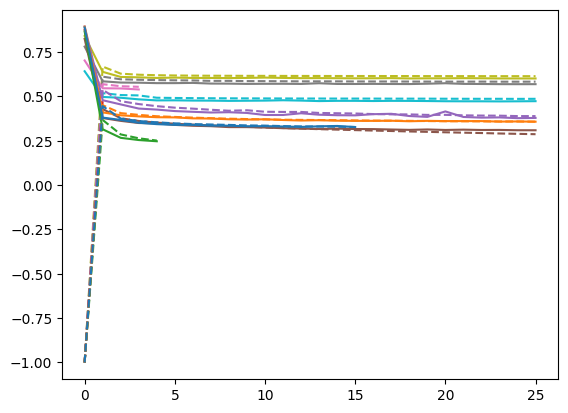

In [108]:
MAX_EPOCH = 25

# plot train and test loss
import matplotlib.colors as mcolors
plot_colors = list(mcolors.TABLEAU_COLORS.keys())
# plot_colors = ["b", "g", "r", "c", "m", "y", "k"]
plt.figure()
for key, value in metrics_dict.items():
    _metrics_path = os.path.join(value, "metrics.json")
    assert os.path.exists(_metrics_path), f"Path {_metrics_path} does not exist"
    _test_metrics = json.load(open(_metrics_path))

    color = plot_colors.pop()
    train_loss = np.array(_test_metrics["LOSS"])
    train_loss = train_loss[:MAX_EPOCH+1]
    plt.plot(train_loss, label=key + " (train)", color=color, linestyle="--")

    test_loss = np.array(_test_metrics["MSE"]) + np.array(_test_metrics["LPIPS_Vgg"])
    test_loss = test_loss[:MAX_EPOCH+1]
    plt.plot(test_loss, label=key + " (test)", linestyle="-", color=color)

    best_epoch = np.argmin(test_loss)
    print(f"\n-- {key} --")
    print(f"Best epoch for {key}: {best_epoch} / {len(test_loss)-1}")
    print(f"Best test loss for {key}: {test_loss[best_epoch]}")
    # print metrics
    print(f"PSNR: {np.array(_test_metrics['PSNR'])[best_epoch]}")
    print(f"SSIM: {np.array(_test_metrics['SSIM'])[best_epoch]}")
    print(f"LPIPS_Vgg: {np.array(_test_metrics['LPIPS_Vgg'])[best_epoch]}")

plt.xlabel("Epoch")
plt.title("Train-test loss")

#legend outside
plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1.0))
plt.ylim([0.1, 0.35]);
plt.xlim([0, MAX_EPOCH]);

plt.grid()


# plot intermediate outputs

Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-12/18-55-34/recon_epochBEST


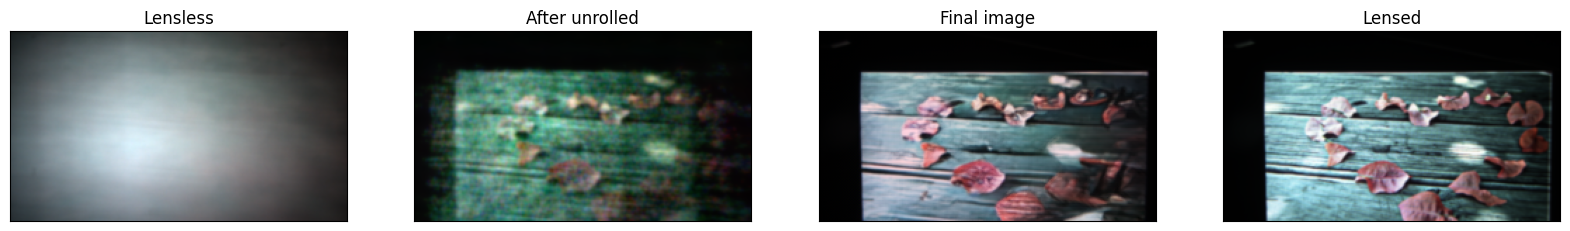

In [ ]:
model = "U20+Drunet(res0.1)"
# model = "Unet+U20+Drunet(res0.1)"
# model = "U20"
idx = 0

# get data
lensless, lensed = test_set[idx]

# load model
recon = load_model(metrics_dict[model], device=device)

# apply
with torch.no_grad():
    recon.set_data(lensless.unsqueeze(0).to(device))
    final, pre, pre_post = recon.apply(
        plot=False,
        save=False,
        output_intermediate=True,
    )

# plot
if pre is not None:
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
elif pre_post is not None:
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
else:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

plot_function(lensless, ax=axs[0])
axs[0].set_title("Lensless")
if pre is not None:
    plot_function(pre, ax=axs[1], color_correct=True)
    axs[1].set_title("After pre-processor")
    plot_function(pre_post, ax=axs[2], color_correct=True)
    axs[2].set_title("After unrolled")
    plot_function(final, ax=axs[3])
    axs[3].set_title("Final image")
    plot_function(lensed, ax=axs[4])
    axs[4].set_title("Lensed")
elif pre_post is not None:
    plot_function(pre_post, ax=axs[1])
    axs[1].set_title("After unrolled")
    plot_function(final, ax=axs[2])
    axs[2].set_title("Final image")
    plot_function(lensed, ax=axs[3])
    axs[3].set_title("Lensed")
else:
    plot_function(final, ax=axs[1])
    axs[1].set_title("Final image")
    plot_function(lensed, ax=axs[2])
    axs[2].set_title("Lensed")
plt.show()
